In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
import scipy.io as sio
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

In [6]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [7]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [8]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
def preprocess(wav):
    wav = sklearn.preprocessing.maxabs_scale(wav)
    wav_mfcc = librosa.feature.mfcc(y=wav, n_mfcc=13)
    wav_mfcc_std = StandardScaler().fit_transform(wav_mfcc)
    wav_mfcc_std_mean = wav_mfcc_std.mean(axis=1)

    features = np.concatenate([wav_mfcc_std_mean])
    return features

In [10]:
def build_batchnorm_cnn(conv_num=1, fcn_num=1):
    model=Sequential()
    model.add(Conv1D(kernel_size=25, filters=8, strides=1, padding='valid', 
                  activation='relu', input_shape=input_shape))  
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=8*(2**(i+1)), strides=1, padding='valid', 
                          activation='relu'))  
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))

    model.add(Flatten())
    
    for i in range(fcn_num):
        model.add(Dense( 1024/(2**i), activation='relu' ))
        model.add(Dropout(0.5))
    
    model.add(Dense(output_size, activation='softmax' ))
    return model

In [11]:
# model = build_cnn(conv_num=3, fcn_num=1)
# model.summary()

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.4757 - acc: 0.3335
Epoch 00001: val_loss improved from inf to 1.66259, saving model to model/checkpoint/1D_BN_CNN_1_conv_1_fcn_checkpoint/01-1.6626.hdf5
36805/36805 [==============================] - 32s 856us/step - loss: 2.4756 - acc: 0.3335 - val_loss: 1.6626 - val_acc: 0.5479
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.3266 - acc: 0.5931
Epoch 00002: val_loss improved from 1.66259 to 1.14209, saving model to model/checkpoint/1D_BN_CNN_1_conv_1_fcn_checkpoint/02-1.1421.hdf5
36805/36805 [==============================] - 29s 800us/step - loss: 1.3264 - acc: 0.5932 - val_loss: 1.1421 - val_acc: 0.6536
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.8941 - acc: 0.7200
Epoch 00003: val_loss improved from 1.14209 to 1.07957, saving model to model/checkpoint/1D_BN_CNN_1_conv_1_fcn_checkpoint/03-1.0796.hd

Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0668 - acc: 0.9826
Epoch 00029: val_loss did not improve from 1.00490
36805/36805 [==============================] - 29s 780us/step - loss: 0.0668 - acc: 0.9826 - val_loss: 1.4397 - val_acc: 0.7296
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0698 - acc: 0.9819
Epoch 00030: val_loss did not improve from 1.00490
36805/36805 [==============================] - 29s 780us/step - loss: 0.0697 - acc: 0.9819 - val_loss: 1.3353 - val_acc: 0.7419
Epoch 31/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0617 - acc: 0.9840
Epoch 00031: val_loss did not improve from 1.00490
36805/36805 [==============================] - 29s 780us/step - loss: 0.0617 - acc: 0.9840 - val_loss: 1.4550 - val_acc: 0.7370
Epoch 32/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0656 - acc: 0.9824
Epoch 00032: val_loss did not improve from 1.00490
36805/36805 [===========

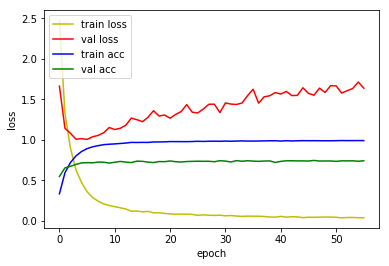

4815/4815 [==============================] - 1s 168us/step
Loss: 1.208793905071009 Accuracy: 0.6616822429968436

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 2.8699 - acc: 0.1943
Epoch 00001: val_loss improved from inf to 2.14194, saving model to model/checkpoint/1D_BN_CNN_1_conv_2_fcn_checkpoint/01-2.1419.hdf5
36805/36805 [==============================] - 30s 818us/step - loss: 2.8688 - acc: 0.1945 - val_loss: 2.1419 - val_acc: 0.4079
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.9925 - acc: 0.3727
Epoch 00002: val_loss improved from 2.14194 to 1.52403, saving model to model/checkpoint/1D_BN_CNN_1_conv_2_fcn_checkpoint/02-1.5240.hdf5
36805/36805 [==============================] - 29s 795us/step - loss: 1.9924 - acc: 0.3727 - val_loss: 1.5240 - val_acc: 0.5255
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.6248 - acc: 0.4825
Epoch 00003: val_loss 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1277 - acc: 0.9619
Epoch 00027: val_loss did not improve from 0.81867
36805/36805 [==============================] - 29s 788us/step - loss: 0.1277 - acc: 0.9619 - val_loss: 1.0397 - val_acc: 0.7501
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1223 - acc: 0.9630
Epoch 00028: val_loss did not improve from 0.81867
36805/36805 [==============================] - 29s 787us/step - loss: 0.1223 - acc: 0.9630 - val_loss: 1.0828 - val_acc: 0.7480
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1210 - acc: 0.9644
Epoch 00029: val_loss did not improve from 0.81867
36805/36805 [==============================] - 29s 787us/step - loss: 0.1209 - acc: 0.9644 - val_loss: 1.0972 - val_acc: 0.7442
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1188 - acc: 0.9637
Epoch 00030: val_loss did not improve from 0.81867
36805/36805 [========================

Epoch 57/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0553 - acc: 0.9843
Epoch 00057: val_loss did not improve from 0.81867
36805/36805 [==============================] - 29s 791us/step - loss: 0.0553 - acc: 0.9843 - val_loss: 1.3387 - val_acc: 0.7545
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0606 - acc: 0.9829
Epoch 00058: val_loss did not improve from 0.81867
36805/36805 [==============================] - 29s 790us/step - loss: 0.0606 - acc: 0.9829 - val_loss: 1.2475 - val_acc: 0.7538
Epoch 59/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0633 - acc: 0.9832
Epoch 00059: val_loss did not improve from 0.81867
36805/36805 [==============================] - 29s 791us/step - loss: 0.0632 - acc: 0.9832 - val_loss: 1.2388 - val_acc: 0.7622

1 Conv 2 FCN Model


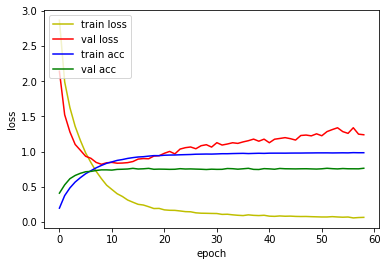

4815/4815 [==============================] - 1s 188us/step
Loss: 0.9895170656691459 Accuracy: 0.7021806854325292

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
 8000/36805 [=====>........................] - ETA: 23s - loss: 3.1720 - acc: 0.2193

ResourceExhaustedError: OOM when allocating tensor with shape[15888,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_4/Adam/mul_42}} = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_4/Adam/sub_26, training_4/Adam/gradients/dense_5/MatMul_grad/MatMul_1)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [14]:
for i in range(1, 6):
    for j in range(1, 3):
        model = build_batchnorm_cnn(conv_num=i, fcn_num=j)
#         model.summary()
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])
    
        model_path = 'model/checkpoint/1D_BN_CNN_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        os.makedirs(model_path, exist_ok=True)
        model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
        checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                       verbose=1, save_best_only=True)

        early_stopping = EarlyStopping(monitor='val_loss', patience=50)
        hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=200, 
                         validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                         callbacks = [checkpointer, early_stopping])
        print()
        print('{} Conv {} FCN Model'.format(i, j))
        fig, ax = plt.subplots()
        ax.plot(hist.history['loss'], 'y', label='train loss')
        ax.plot(hist.history['val_loss'], 'r', label='val loss')
        ax.plot(hist.history['acc'], 'b', label='train acc')
        ax.plot(hist.history['val_acc'], 'g', label='val acc')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        plt.show()

        png_path = 'visualization/learning_curve/'
        filename = '1D_BN_CNN_{}_conv_{}_fcn'.format(i, j)+'.png'
        os.makedirs(png_path, exist_ok=True)
        fig.savefig(png_path+filename, transparent=True)

        del(model)
        
        model_path = 'model/checkpoint/1D_BN_CNN_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
        model = load_model(model_filename)
        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

In [ ]:
for i in range(1, 6):
    for j in range(1, 3):
        print()
        print('{} Conv {} FCN Model'.format(i, j))
#         model = build_cnn(conv_num=i, fcn_num=j)
        model_path = 'model/checkpoint/1D_BN_CNN_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'
  
        model = load_model(model_filename)
        model.summary()
    
        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        
        del(model)